# Chapter 6 - Linear Model Selection and Regularization

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)

In [1]:
%load_ext autoreload
%autoreload 2
import sys

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# conda install -c conda-forge glmnet
# import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

#from sklearn.decomposition import PCA
#rom sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#import sklearn.linear_model as skl_lm
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import  LeaveOneOut, KFold, cross_val_score


%matplotlib inline
plt.style.use('seaborn-white')

# Lab 2

In [3]:
# Dataset from package 'ISLR' to a csv file.
df = pd.read_csv('../data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [4]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [5]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [6]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
#X.info()

In [7]:
X.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0


#### Split to training/test sets.

In [8]:
#X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
#y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
#X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
#y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)  # test_size=t_prop, random_state=Y[i,j])


### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$
    
Simialarly, there is a sklearn function for LASSO - see further down.

In [10]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas = 10**np.linspace(2,-2,100)*0.5

In [11]:
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

In [12]:
#coefs

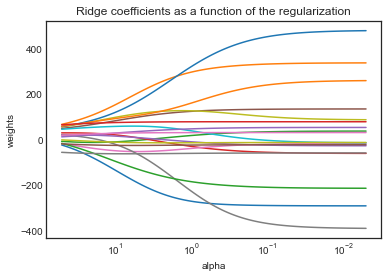

In [13]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [14]:
import sklearn.preprocessing as prepro

In [15]:
#prepro.scale?

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [17]:
len(X_)*11498/2

1511987.0

In [18]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)

Ridge(alpha=1511987.0)

In [19]:
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

192220.97545495618

In [20]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.023633
Hits           0.025531
HmRun          0.021786
Runs           0.024333
RBI            0.026155
Walks          0.027746
Years          0.026690
CAtBat         0.033081
CHits          0.033697
CHmRun         0.035498
CRuns          0.034854
CRBI           0.036451
CWalks         0.032299
PutOuts        0.016841
Assists        0.004123
Errors        -0.000872
League_N      -0.001158
Division_W    -0.010385
NewLeague_N   -0.000096
dtype: float64

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [21]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

192370.75728825244

### Compute the regularization path using RidgeCV

In [22]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+01, 4.55581378e+01, 4.15108784e+01, 3.78231664e+01,
       3.44630605e+01, 3.14014572e+01, 2.86118383e+01, 2.60700414e+01,
       2.37540508e+01, 2.16438064e+01, 1.97210303e+01, 1.79690683e+01,
       1.63727458e+01, 1.49182362e+01, 1.35929412e+01, 1.23853818e+01,
       1.12850986e+01, 1.02825615e+01, 9.36908711e+00, 8.53676324e+00,
       7.77838072e+00, 7.08737081e+0...
       4.24876718e-02, 3.87131841e-02, 3.52740116e-02, 3.21403656e-02,
       2.92851041e-02, 2.66834962e-02, 2.43130079e-02, 2.21531073e-02,
       2.01850863e-02, 1.83918989e-02, 1.67580133e-02, 1.52692775e-02,
       1.39127970e-02, 1.26768225e-02, 1.15506485e-02, 1.05245207e-02,
       9.58955131e-03, 8.73764200e-03, 7.96141397e-03, 7.25414389e-03,
       6.60970574e-03, 6.02251770e-03, 5.48749383e-03, 5.00000000e-03]),
        scoring='neg_mean_squared_error')

In [23]:
ridgecv.alpha_

50.0

In [24]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
# 97384.92959172592

111513.13802926984

In [25]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat         -15.285143
Hits           49.503514
HmRun          12.263940
Runs           22.727021
RBI            14.425150
Walks          44.977543
Years          -2.607950
CAtBat         16.894688
CHits          34.294872
CHmRun         66.525884
CRuns          41.793551
CRBI           57.762552
CWalks          7.023552
PutOuts        47.910211
Assists        30.133143
Errors        -19.675806
League_N        8.391344
Division_W    -47.314040
NewLeague_N    16.161180
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

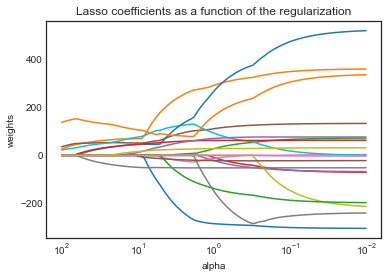

In [26]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [27]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(cv=10, max_iter=10000)

In [28]:
lassocv.alpha_

3.00275834710658

In [29]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102338.06452536737

In [30]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat         -216.609037
Hits           238.911413
HmRun            4.144877
Runs             0.000000
RBI             -0.000000
Walks           88.025810
Years          -20.847932
CAtBat          -0.000000
CHits            0.000000
CHmRun         122.139488
CRuns          116.957010
CRBI            82.214420
CWalks         -69.912395
PutOuts         57.887887
Assists         51.174708
Errors         -17.827209
League_N         0.000000
Division_W     -51.776697
NewLeague_N     25.034224
dtype: float64

#### Note that some of the estimated coefficients (Runs, RBI, CatBat, CHits and League_N), unlike in Ridge regression, are 0.